# **Classify promotion buyers through predictive techniques**

Big Corp. Inc. is in the early stages of working in a data-driven fashion. Currently, they are investigating how promoting products can be used to increase revenue. Big Corp. Inc. has historically collected data on this, but no one in the company has ever looked at it in greater detail.

You are now tasked with delivering a model capable of classifying customers as 
likely buyers of promoted items or not based on this historic data.

In [1]:
# Install H2O framework if it not installed already
!pip3 install --upgrade h2o

     |████████████████████████████████| 123.7MB 96kB/s 
  Created wheel for h2o: filename=h2o-3.26.0.11-py2.py3-none-any.whl size=123721708 sha256=f4e24b2f686facae0e79062ca91c5f572204c32794c878508776efa8cc9fcaac
  Stored in directory: /root/.cache/pip/wheels/71/e6/ed/fb9be80ae2eb0bef9deada74fc370b2532f578d8b00bc1a8fb
Successfully built h2o


In [0]:
from google.colab import files

import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.automl import H2OAutoML

In [0]:
# Configure some general settings for graphs
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [5]:
# Upload the data (code snippet provided by Google Colab)
uploaded = files.upload()

for fn in uploaded.keys():
  print('Uploaded file "{name}" from local file system with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving promotional_sales.csv to promotional_sales.csv
Uploaded file "promotional_sales.csv" from local file system with length 1444095 bytes


In [0]:
# Load the data into a Pandas dataframe
raw_data = pd.read_csv("./promotional_sales.csv")

# (Some minimal) exploratory analysis

Mostly looking at irrelevant variables (e.g., those with the same value for all rows), duplicate variables (e.g., those that are correlated) and noisy variables (e.g., those with too many missing, NaNs, values)  to figure out some of the following questions given the supplied information about the problem:

* Is there some data correlating each other? (i.e., are there attributes depending on each other?)
* Could we infer some categorical data from the attributes (i.e., is the range of values for some attribute limited enough to assume some sort of encoding?)
* How balanced (or imbalaced) is the data? (i.e., how many promotion buyers are in the dataset vs. those that are not promotion buyers?)

In [7]:
# Let's take a quick look at the data
raw_data.head()

,Customer ID,Gender,Age,Country,Membership Reward Status,Neighborhood Type,Income Bracket,Sign-Up Bonus,Membership in Months,ID of Favorite Product,Total Spend,Promotion Purchase Count,Promotion Purchase Indicator
0,140,M,76,DK,Gold,C,10,1,NaN,6d1645c536,16000.00,0,0
1,620,M,49,DK,Gold,D,4,1,NaN,f6923d15c6,6000.00,0,0
2,868,F,70,DK,Bronze,D,5,1,8.0,29fd49fbe8,0.02,1,1
3,1120,M,65,DK,None,F,10,1,NaN,6c0d6497c2,0.01,1,1
4,2313,F,68,DK,None,A,11,1,8.0,96b8e0c752,0.01,0,0


In [0]:
# Convert attribute 'Customer ID' into a string as it is an ID but it may be interpreted as integer
raw_data['Customer ID'] = raw_data['Customer ID'].astype(str)

In [9]:
# And more precisely to some standard metrics on each column 
raw_data.describe()

,Age,Sign-Up Bonus,Membership in Months,Total Spend,Promotion Purchase Count,Promotion Purchase Indicator
count,22223.000000,22223.0,10074.000000,22223.000000,22223.000000,22223.000000
mean,50.078747,1.0,6.554497,4420.590039,0.294740,0.247716
std,18.775112,0.0,4.629107,7559.047497,0.562831,0.431696
min,-1.000000,1.0,0.000000,0.010000,0.000000,0.000000
25%,41.000000,1.0,4.000000,0.010000,0.000000,0.000000
50%,52.000000,1.0,5.000000,2000.000000,0.000000,0.000000
75%,63.000000,1.0,8.000000,6000.000000,0.000000,0.000000
max,79.000000,1.0,39.000000,296313.850000,3.000000,1.000000


It seems that `Membership in Months` has quite some missing values (more than half rows have this attribute missing), `Promotion Purchase Count` and `Promotion Purchase Indicator` are likely to be the same or similar due to a very similar mean and close standard deviation (i.e., to be checked in a bit) and `Sign-Up Bonus` has the same value for all rows.

Otherwise all other attributes seem numerical.

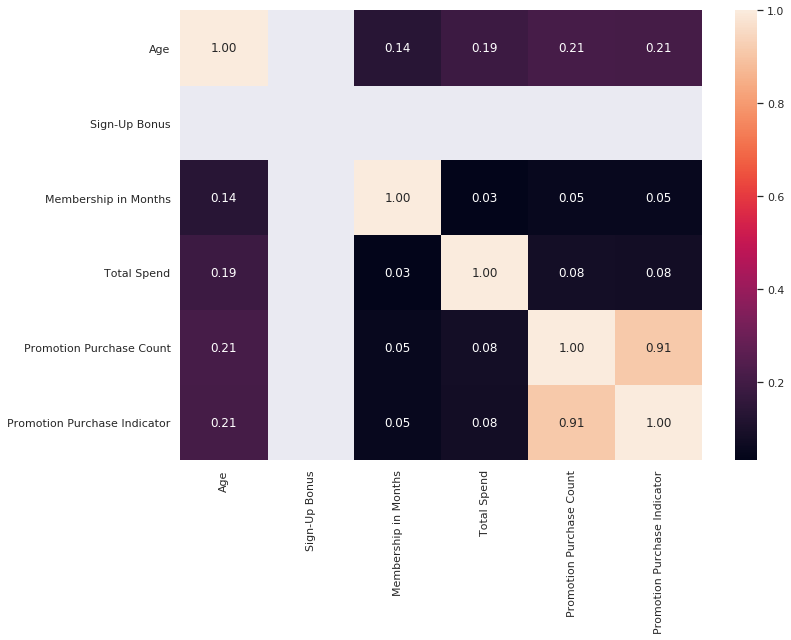

In [10]:
# Some variables can most likely be removed, so let's check for correlations
sns.heatmap(data=raw_data[raw_data.columns].corr().abs(), annot=True, fmt='.2f')

We can confirm the almost perfect correlation between `Promotion Purchase Count` and `Promotion Purchase Indicator` attributes, so one of them will be removed when running algorithms.

Otherwise, the other attributes do not seem to be correlated. Attribute `Sign-Up Bonus` must be removed as it has the same value everywhere.



In [11]:
# And because I am wondering about multicollinearity, let's check for the VIF
def calculate_vif_(X, threshold=5.0):
    # Code snippet adapted from https://stats.stackexchange.com/a/253620
    variables = list(range(X.shape[1]))
    dropped = True
    dropped_variables = []
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > threshold:
            dropped_variables.append(X.iloc[:, variables].columns[maxloc])
            del variables[maxloc]
            dropped = True

    res = X.iloc[:, variables]

    print('Variables to drop: {}'.format(dropped_variables))
    print('Variables (numeric) to keep: {}'.format(res.columns.values.tolist()))
    
    return res

calculate_vif_(raw_data.dropna()._get_numeric_data());

Variables to drop: ['Sign-Up Bonus', 'Promotion Purchase Indicator']
Variables (numeric) to keep: ['Age', 'Membership in Months', 'Total Spend', 'Promotion Purchase Count']


The variance inflation factor (VIF) we see easily what attributes to drop that the heatmap pointed already: `Sign-Up Bonus` and `Promotion Purchase Indicator`.

0    16718
1     5505
Name: Promotion Purchase Indicator, dtype: int64


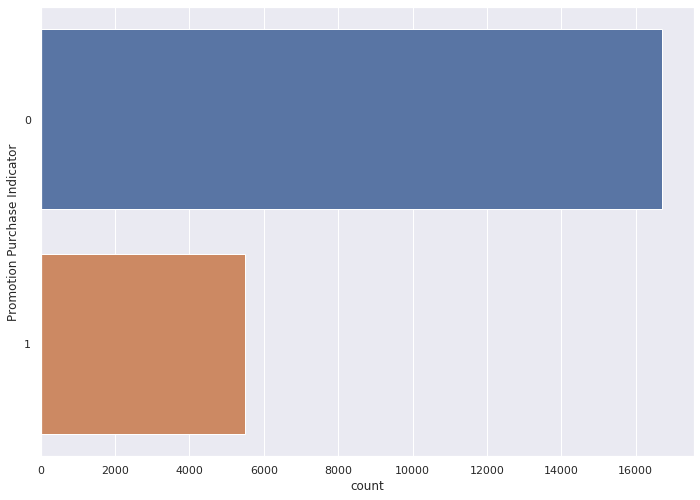

In [12]:
# Now let's check whether we have an imbalaced dataset or not...
sns.countplot(y='Promotion Purchase Indicator', data=raw_data)
print(raw_data['Promotion Purchase Indicator'].value_counts())

We do clearly have a somewhat imbalanced data set. With a ratio of one to three in the target attribute `Promotion Purchase Indicator`.

As the rows are unique (i.e., each row represent a unique customer) this means that there is one customer that acquires something in promotion out of every any random three customers.



## **(Some) machine learning¶**

In order to do some prediction we are going to leverage on machine learning algorithms. I will try one of them and possibly explore the AutoML feature of the framework H2O.

There is a catch with this dataset though because it is imbalanced. A typical solution to the imbalance problem is to even the classes to classify by resampling (e.g., 50% for target's value 0 and another 50% for target's value 1) at the cost of losing information (if downsampling) or duplicating entries and possibly overfitting (if upsampling).

Another typical solution could be to aggregate attributes (features) but every row represents a unique customer, hence the aggregation implies losing information (else we could try to aggregate similar customers, i.e., clustering). Another option, should the results are not good enough, could be deriving new features from the current ones.

In [13]:
# Initialise the H2O 'cluster' (Java is needed, otherwise this will fail)
h2o.init(ip="localhost", port=54323)
# Clean the cluster in case it was already running
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54323 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpjztt0t4i
  JVM stdout: /tmp/tmpjztt0t4i/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpjztt0t4i/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.11
H2O cluster version age:,6 days
H2O cluster name:,H2O_from_python_unknownUser_ce0sj6
H2O cluster total nodes:,1
H2O cluster free memory:,2.938 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


In [14]:
# Load the data into a H2OFrame
data = h2o.import_file(os.path.realpath("./promotional_sales.csv"))
data.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:22223
Cols:13




,Customer ID,Gender,Age,Country,Membership Reward Status,Neighborhood Type,Income Bracket,Sign-Up Bonus,Membership in Months,ID of Favorite Product,Total Spend,Promotion Purchase Count,Promotion Purchase Indicator
type,int,enum,int,enum,enum,enum,int,int,int,enum,real,int,int
mins,140.0,,-1.0,,,,0.0,1.0,0.0,,0.01,0.0,0.0
mean,26055403.439859618,,50.078747243846486,,,,8.286549970751022,1.0,6.5544967242406225,,4420.590039148629,0.2947396841110562,0.2477163299284525
maxs,52856469.0,,79.0,,,,34.0,1.0,39.0,,296313.85,3.0,1.0
sigma,15074974.057352416,,18.775111815986183,,,,3.8285013797319873,0.0,4.62910673209617,,7559.047497144183,0.5628309212318786,0.4316958834432313
zeros,0,,0,,,,1091,0,18,,0,16718,16718
missing,0,0,0,0,0,0,0,0,12149,0,0,0,0
0,140.0,M,76.0,DK,Gold,C,10.0,1.0,nan,6d1645c536,16000.0,0.0,0.0
1,620.0,M,49.0,DK,Gold,D,4.0,1.0,nan,f6923d15c6,6000.0,0.0,0.0
2,868.0,F,70.0,DK,Bronze,D,5.0,1.0,8.0,29fd49fbe8,0.02,1.0,1.0


In [0]:
# Configure the predictors (features) and the response (target)
predictors = list(set(data.col_names))
response = 'Promotion Purchase Indicator'
# Remove the target and some attributes mentioned above
predictors.remove(response)
predictors.remove('Promotion Purchase Count')
predictors.remove('Customer ID')
predictors.remove('Sign-Up Bonus')

In [0]:
# As we are on a classification problem... the response should be of a categorical kind.
data[response] = data[response].asfactor()
# And the same for some other attributes
data['Income Bracket'] = data['Income Bracket'].asfactor()

In [0]:
# And we also do some train/test/validation split
trn_h2o, tst_h2o, vld_h2o = data.split_frame([0.7, 0.15], seed=1234)

In [18]:
# We try logistic regression (a generalized linear model) with our probability distribution as binomial (or Bernoulli if you prefer)
glm_bi_v1 = H2OGeneralizedLinearEstimator(
                    model_id='glm_v1',
                    family='binomial',
                    solver='L_BFGS',
                    nfolds=25,
                    lambda_=0.00001, # This value is just a guess...
                    balance_classes=True) # This does not matter much according to the official documentation.
glm_bi_v1.train(predictors, response, training_frame=trn_h2o, validation_frame=vld_h2o)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [19]:
# Show the confussion matrix
glm_bi_v1.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17826710047385128: 


,,0,1,Error,Rate
0,0,1581.0,898.0,0.3622,(898.0/2479.0)
1,1,223.0,583.0,0.2767,(223.0/806.0)
2,Total,1804.0,1481.0,0.3412,(1121.0/3285.0)


In [20]:
# Show the accuracy
glm_bi_v1.accuracy(valid=True)

[[0.700568901439802, 0.7753424657534247]]

In [21]:
# Try again logistic regression with lambda search: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/lambda_search.html
glm_bi_search_v1 = H2OGeneralizedLinearEstimator(
                        model_id='glm_v1_1',            
                        family='binomial',
                        solver='L_BFGS',
                        nfolds=25,
                        lambda_search=True,
                        balance_classes=True) # This does not matter much according to the official documentation.
glm_bi_search_v1.train(predictors, response, training_frame=trn_h2o, validation_frame=vld_h2o)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [22]:
# Show the confussion matrix
glm_bi_search_v1.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.26063005389730504: 


,,0,1,Error,Rate
0,0,1814.0,665.0,0.2683,(665.0/2479.0)
1,1,238.0,568.0,0.2953,(238.0/806.0)
2,Total,2052.0,1233.0,0.2749,(903.0/3285.0)


In [23]:
# Show the accuracy
glm_bi_search_v1.accuracy(valid=True)

[[0.5248200398699455, 0.7917808219178082]]

In [0]:
# We are going to try adding some features by bucketizing current ones
# Credits: https://github.com/h2oai/h2o-tutorials/blob/58491416bcb1d93c87df63eee60c76d63c7160be/tutorials/glm/glm_h2oworld_demo.py#L220-L244
def cut_column(train_df, train, valid, test, col):
    '''
    Convenience function to change a column from numerical to categorical
    We use train_df only for bucketing with histograms.
    Uses np.histogram to generate a histogram, with the buckets forming the categories of our new categorical.
    Picks buckets based on training data, then applies the same classification to the test and validation sets
    
    Assumes that train, valid, test will have the same histogram behavior.
    '''
    only_col = train_df[col]                            # Isolate the column in question from the training frame
    counts, breaks = np.histogram(only_col, bins=20)   # Generate counts and breaks for our histogram
    min_val = min(only_col)-1                          # Establish min and max values
    max_val = max(only_col)+1
    
    new_b = [min_val]                                  # Redefine breaks such that each bucket has enough support
    for i in range(19):
        if counts[i] > 1000 and counts[i+1] > 1000:
            new_b.append(breaks[i+1])
    new_b.append(max_val)
    
    names = [col + '_' + str(x) for x in range(len(new_b)-1)]  #Generate names for buckets, these will be categorical names

    train[col+"_cut"] = train[col].cut(breaks=new_b, labels=names)
    valid[col+"_cut"] = valid[col].cut(breaks=new_b, labels=names)
    test[col+"_cut"] = test[col].cut(breaks=new_b, labels=names)

In [0]:
# Convert the train dataset into a data frame
trn_h2o_df = trn_h2o.as_data_frame(True)

In [0]:
# Make a couple of attributes categoricals
cut_column(trn_h2o_df, trn_h2o, vld_h2o, tst_h2o, "Age")
# cut_column(trn_h2o_df, trn_h2o, vld_h2o, tst_h2o, "Membership in Months")
cut_column(trn_h2o_df, trn_h2o, vld_h2o, tst_h2o, "Total Spend")

In [27]:
# Generate pairwise columns
interaction_columns = ['Age_cut', 'Total Spend_cut']
trn_h2o_cols = trn_h2o.interaction(factors=interaction_columns,    
                                   pairwise=True,
                                   max_factors=1000,
                                   min_occurrence=100,
                                   destination_frame="itrain")
vld_h2o_cols = vld_h2o.interaction(factors=interaction_columns,
                                   pairwise=True,
                                   max_factors=1000,
                                   min_occurrence=100,
                                   destination_frame="ivalid")
tst_h2o_cols = tst_h2o.interaction(factors=interaction_columns,
                                   pairwise=True,
                                   max_factors=1000,
                                   min_occurrence=100,
                                   destination_frame="itest")

Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%


In [0]:
# Append pairwise columns to the H2OFrame
trn_h2o = trn_h2o.cbind(trn_h2o_cols)
vld_h2o = vld_h2o.cbind(vld_h2o_cols)
tst_h2o = tst_h2o.cbind(tst_h2o_cols)

In [29]:
# Try again
glm_bi_v2 = H2OGeneralizedLinearEstimator(
                    model_id='glm_v2',
                    family='binomial',
                    solver='L_BFGS',
                    nfolds=25,
                    lambda_=0.00001,
                    balance_classes=True)
glm_bi_v2.train(predictors, response, training_frame=trn_h2o, validation_frame=vld_h2o)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [30]:
# Show the confussion matrix
glm_bi_v2.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17826710047385128: 


,,0,1,Error,Rate
0,0,1581.0,898.0,0.3622,(898.0/2479.0)
1,1,223.0,583.0,0.2767,(223.0/806.0)
2,Total,1804.0,1481.0,0.3412,(1121.0/3285.0)


In [31]:
# Show the accuracy
glm_bi_v2.accuracy(valid=True)

[[0.700568901439802, 0.7753424657534247]]

## **Some H2O AutoML**


In [32]:
# Clean the running cluster
h2o.remove_all()
# Reload the data into a H2OFrame and split the data again
data = h2o.import_file(os.path.realpath("./promotional_sales.csv"))
trn_h2o, tst_h2o, vld_h2o = data.split_frame([0.7, 0.15], seed=1234)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [33]:
# Run AutoML for 15 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=15,
                seed=1234,
                balance_classes=True)
aml.train(x=predictors,
          y=response,
          training_frame = trn_h2o,
          validation_frame = vld_h2o)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [34]:
# View the AutoML leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20191211_230105,0.133326,0.365138,0.133326,0.266993,0.256111
StackedEnsemble_BestOfFamily_AutoML_20191211_230105,0.133373,0.365202,0.133373,0.26713,0.256229
XGBoost_grid_1_AutoML_20191211_230105_model_2,0.133398,0.365237,0.133398,0.271104,0.25636
XGBoost_grid_1_AutoML_20191211_230105_model_1,0.133495,0.36537,0.133495,0.270138,0.256486
XGBoost_3_AutoML_20191211_230105,0.133511,0.365391,0.133511,0.27074,0.256315
GBM_1_AutoML_20191211_230105,0.135502,0.368106,0.135502,0.268212,0.257844
GBM_5_AutoML_20191211_230105,0.136074,0.368882,0.136074,0.26756,0.258619
GBM_2_AutoML_20191211_230105,0.136314,0.369207,0.136314,0.266815,0.258741
GBM_grid_1_AutoML_20191211_230105_model_1,0.137257,0.370482,0.137257,0.281194,0.259598
GBM_3_AutoML_20191211_230105,0.137981,0.371459,0.137981,0.26608,0.259969


In [49]:
# Some information about the leader model
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20191211_230105

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.12489368016028472
RMSE: 0.3534029996481138
MAE: 0.25852582708077476
RMSLE: 0.24758434849820599
R^2: 0.32579778428056216
Mean Residual Deviance: 0.12489368016028472
Null degrees of freedom: 15614
Residual degrees of freedom: 15608
Null deviance: 2892.6259365994492
Residual deviance: 1950.214815702846
AIC: 11845.683592732279

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 0.12966090322848678
RMSE: 0.3600845778820398
MAE: 0.26328938524241213
RMSLE: 0.25300995227493206
R^2: 0.29972564557577575
Mean Residual Deviance: 0.12966090322848678
Null degrees of freedom: 3284
Residual degrees of freedom: 3278
Null deviance: 608.2418058450836
Residual deviance: 425.93606710557907
AIC: 2627.7208319259234

ModelMetricsRegressionGLM:

In [65]:
# Compute some predictions on the test set
predictions_automl_h2o = m.predict(vld_h2o)
# And present some of the predictions computed
predictions_automl_h2o.head()

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict
0.0979992
0.749705
0.914867
0.284413
0.0374087
0.221132
0.0572138
0.138939
0.084806
0.0853066


In [0]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_BestOfFamily" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])
%matplotlib inline
metalearner.std_coef_plot()

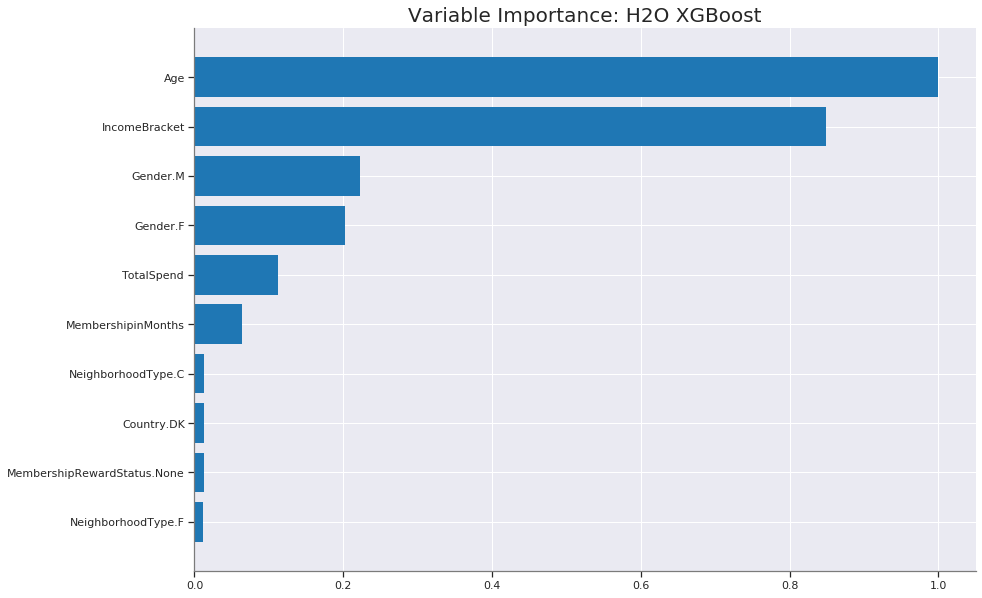

In [62]:
# Finally some attribute (feature) importance, for fun I guess of XGBoost
%matplotlib inline
m = h2o.get_model(lb[2,"model_id"])
m.varimp_plot()

# **Conclusions and future work**

The problem presented here is quite similar (if not the same) as the typical scenario of customer attrition (or churn). Where in churn we have 'customers' here we have promotion purchase indicator, and when in churn the customer cancels the service or subscription here we have a a customer that does not carry out the promotional purchase.

It is relatively hard to predict accurately on imbalanced data without loss of information, particularly when the ratio of data to classify with is notably skewed and when the amount of data itself is limited. Therefore, some compromises are to be taken, usually by imputing information, else losing information when downsampling. Moreover, the aggregation of data per customer causes in its own a loss of information as there could be some patterns when it comes to individual amounts of items purchase as opposed to providing a total amount.

There are many things still to do with this dataset (and much more I guess with contextual information on the dataset features (attributes). For example,

* With more data it would be great to test some  efficiently but not necessarily that should outperform other algorithms.
* Trying more algorithms (AutoML from H2O is precisely a good helper on this to do automatically).
* ...